# Classifying Blood Smears with a Convolutional Neural Network


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch03_CNN/ec03_A_blood_smears/blood_smears.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [ ]:
!pip install deeplay  # Uncomment if using Colab/Kaggle.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

This notebook provides you with a complete code example that loads the malaria dataset, trains a convolutional neural network with dense top to classify the images of cells with and without malaria, analyzes where the trained network fails, and shows the network activations and heatmaps.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 3-A from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the Malaria Dataset

This dataset was originally published in S. Rajaraman, S. K. Antani, M. Poost- chi, K. Silamut, Md A. Hossain, R. J. Maude, S. Jaeger, and G. R. Thoma. _Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images._ PeerJ 6, e4568, 2018.

It is available at https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip.


In [ ]:
import os
from torchvision.datasets.utils import _extract_zip, download_url

dataset_path = os.path.join(".", "blood_smears_dataset")
if not os.path.exists(dataset_path):
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    download_url(url, ".")
    _extract_zip("cell_images.zip", dataset_path, None)
    os.remove("cell_images.zip")

100%|██████████| 353M/353M [00:01<00:00, 218MB/s]


### Transforming the Images and Their Ground Thruth

Define a transformation to resize the images to 28 by 28 pixels and convert them to PyTorch tensors (note that `ToTensor()` also normalizes their values between 0 and 1) ...

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor

image_trans = Compose([Resize((28, 28)), ToTensor()])

... define a transformation to make the target label equal to 0 for the uninfected cells and to 1 for the parasitized ones, converting it into a floating-point PyTorch tensor and adding a new dimension for batch processing ...

In [ ]:
import torch

def label_trans(label):
    """Transform label."""
    return torch.tensor(1 - label).float().unsqueeze(-1)

... and define a dataset that also makes these transformations.

In [ ]:
from torchvision.datasets import ImageFolder

base_dir = os.path.join(dataset_path, "cell_images")
dataset = ImageFolder(base_dir, transform=image_trans,
                      target_transform=label_trans)

### Visualizing the Blood Smears

Implement a function to plot some examples of blood smears ...

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_blood_smears(dataset, parasitized):
    """Plot blood smears."""
    fig, axs = plt.subplots(3, 6, figsize=(16, 8))
    for ax in axs.ravel():
        image, label = dataset[np.random.randint(0, len(dataset))]
        if isinstance(image, torch.Tensor):
            image, label = image.numpy().transpose(1, 2, 0), label.numpy()
        ax.imshow(image)
        ax.set_title(f"Parasitized ({label})" if label == parasitized
                     else f"Uninfected ({label})", fontsize=16)
    plt.tight_layout()
    plt.show()

... and use it to plot them.

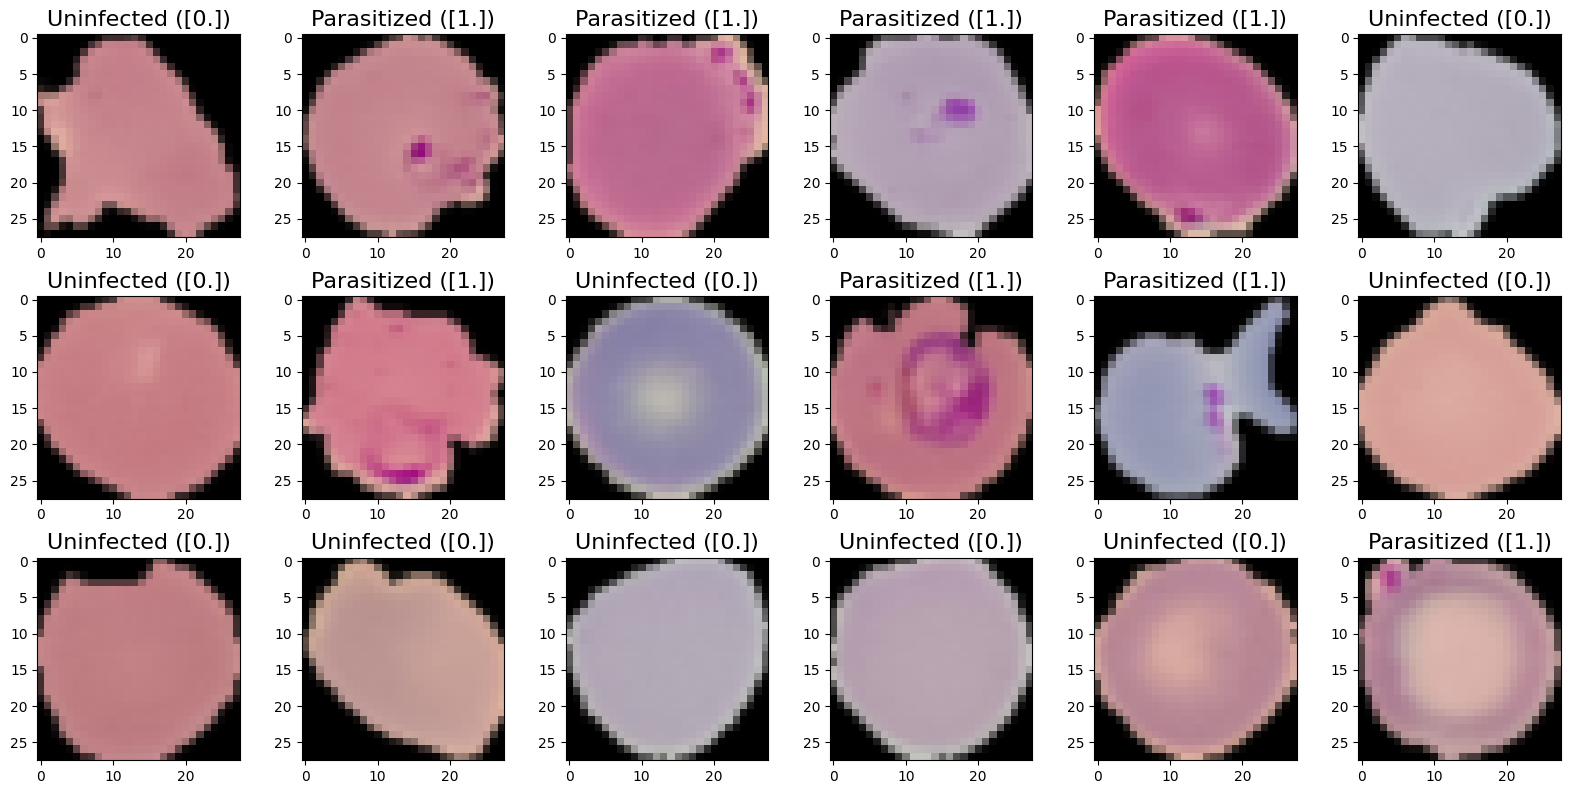

In [ ]:
plot_blood_smears(dataset, parasitized=1)

### Splitting the Dataset and Defining the Data Loaders

Split the dataset, composed by ca. 27,000 cell images, into train (80%) and test (20%) sets ...

In [ ]:
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])

... and define the data loaders.

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=256, shuffle=False)

## Classifying the Blood Smears with Dense Neural Networks

Implement a dense neural network ...

In [ ]:
import deeplay as dl

dnn = dl.MultiLayerPerceptron(
    in_features=28 * 28 *3, hidden_features=[128, 128], out_features=1,
    out_activation=torch.nn.Sigmoid,
)

... print out its detailed architecture ...

In [ ]:
print(dnn)

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LinearBlock(
      (layer): Layer[Linear](in_features=2352, out_features=128, bias=True)
      (activation): Layer[ReLU]()
    )
    (1): LinearBlock(
      (layer): Layer[Linear](in_features=128, out_features=128, bias=True)
      (activation): Layer[ReLU]()
    )
    (2): LinearBlock(
      (layer): Layer[Linear](in_features=128, out_features=1, bias=True)
      (activation): Layer[Sigmoid]()
    )
  )
)


... compile it ...

In [ ]:
dnn_classifier = dl.BinaryClassifier(
    model=dnn, optimizer=dl.RMSprop(lr=0.001),
).create()

... and print out the compiled dense neural network.

In [ ]:
print(dnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Linear(in_features=2352, out_features=128, bias=True)
        (activation): ReLU()
      )
      (1): LinearBlock(
        (layer): Linear(in_features=128, out_features=128, bias=True)
        (activation): ReLU()
      )
      (2): LinearBlock(
        (layer): Linear(in_features=128, out_features=1, bias=True)
        (activation): Sigmoid()
      )
    )
  )
  (optimizer): RMSprop[RMSprop](lr=0.001)
)


The default loss of `dl.BinaryClassifier` is a binary cross-entropy loss.

### Training the Dense Neural Network

In [ ]:
dnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
dnn_trainer.fit(dnn_classifier, train_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                 | Params | Mode 
---------------------------------------------------------------
0 | loss          | BCELoss              | 0      | train
1 | train_metrics | MetricCollection     | 0      | train
2 | val_metrics   | MetricCollection     | 0      | train
3 | test_metrics  | MetricCollection     | 0      | train
4 | model         | MultiLayerPerceptron | 317 K  | train
5 | optimizer     | RMSprop              | 0      | train
---------------------------------------------------------------
317 K     Trainable params
0         Non-trainable params
317 K     Total params
1.271     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                

Training: |          | 0/? [00:00<?, ?it/s]

### Testing the Dense Neural Network

In [ ]:
dnn_trainer.test(dnn_classifier, test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testBinaryAccuracy_epoch  │     0.677009642124176     │
│      test_loss_epoch      │    0.6002065539360046     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.6002065539360046,
  'testBinaryAccuracy_epoch': 0.677009642124176}]

### Plotting the ROC Curve

Implement a function to plot the ROC curve ...

In [ ]:
import torchmetrics as tm

def plot_roc(classifier, loader):
    """Plot ROC curve."""
    roc = tm.ROC(task="binary")
    for image, label in loader:
        roc.update(classifier(image), label.long())

    fig, ax = roc.plot(score=True)
    ax.grid(False)
    ax.axis("square")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc="center right")
    plt.show()

... and use it to plot the performance of the classifier based on a dense neural network.

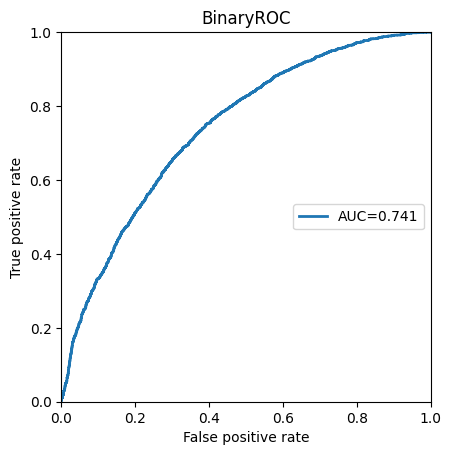

In [ ]:
plot_roc(dnn_classifier, test_loader)

## Classifying the Blood Smears with Convolutional Neural Networks

Implement a convolutional neural network with a dense top ...

In [ ]:
conv_base = dl.ConvolutionalNeuralNetwork(
    in_channels=3, hidden_channels=[16, 16, 32], out_channels=32,
)
conv_base.blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size=2)

connector = dl.Layer(torch.nn.AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(
    in_features=32, hidden_features=[], out_features=1,
    out_activation=torch.nn.Sigmoid,
)

cnn = dl.Sequential(conv_base, connector, dense_top)

... print out its detailed architecture ...

In [ ]:
print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (3): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[Identity]()
      )
    )
  )
  (1): Layer[AdaptiveAvgPool2d](output_size=1)
  (2): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_features=1, bias=Tr

... compile it ...

In [ ]:
cnn_classifier = dl.BinaryClassifier(
    model=cnn, optimizer=dl.RMSprop(lr=0.001),
).create()

... and print out the compiled convolutional neural network.

In [ ]:
print(cnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (3): Conv2dBlock(
          (la

### Training the Convolutional Neural Network

In [ ]:
cnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
cnn_trainer.fit(cnn_classifier, train_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | BCELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 16.7 K | train
5 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
16.7 K    Trainable params
0         Non-trainable params
16.7 K    Total params
0.067     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

### Testing the Convolutional Neural Network

In [ ]:
cnn_trainer.test(cnn_classifier, test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testBinaryAccuracy_epoch  │    0.9428415894508362     │
│      test_loss_epoch      │    0.1571819931268692     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.1571819931268692,
  'testBinaryAccuracy_epoch': 0.9428415894508362}]

### Plotting the ROC Curve

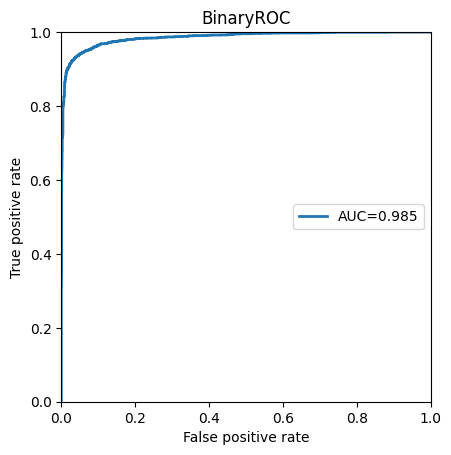

In [ ]:
plot_roc(cnn_classifier, test_loader)

### Checking the Values of the Filters

The following code accesses the 32nd filter's weights in the first convolutional layer of the CNN. It navigates through the model's first module (`model[0]`), selects the initial block (`blocks[0]`), and then targets the layer's weights (`layer.weight[15]`).

In [ ]:
filter = cnn_classifier.model[0].blocks[0].layer.weight[15]

print(filter)

tensor([[[ 0.1729,  0.1203,  0.1066],
         [ 0.1805, -0.1540, -0.0343],
         [ 0.1920,  0.0379, -0.0938]],

        [[ 0.0430,  0.0382,  0.1376],
         [-0.1681, -0.2964, -0.2109],
         [-0.2172, -0.0100,  0.0542]],

        [[-0.0965, -0.0282,  0.1316],
         [-0.1443,  0.1552,  0.0019],
         [-0.0482, -0.1303,  0.0252]]], grad_fn=<SelectBackward0>)


### Visualizing the Activations of the Convolutional Layers

Pick the image of an infected smear to then check the activations it produces on the last convolutional layer ...

In [ ]:
from PIL import Image

im_ind = 0
image_filename = dataset.samples[im_ind][0]
image_hr = Image.open(image_filename)
image = image_trans(image_hr)

... verify whether this image is of a parasitized cell ...

In [ ]:
print(label_trans(dataset.targets[im_ind]))

tensor([1.])


... define a function to visualize the activations ...

In [ ]:
def plot_activations(activations, cols=8):
    """Visualize activations."""
    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis("off")
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i, fontsize=16)
    plt.show()

... add a hook to access the activations in the forward pass ...


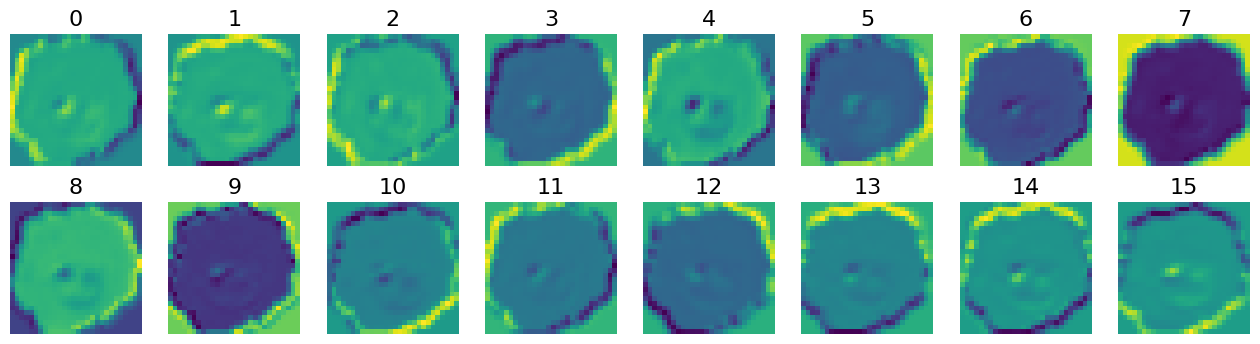

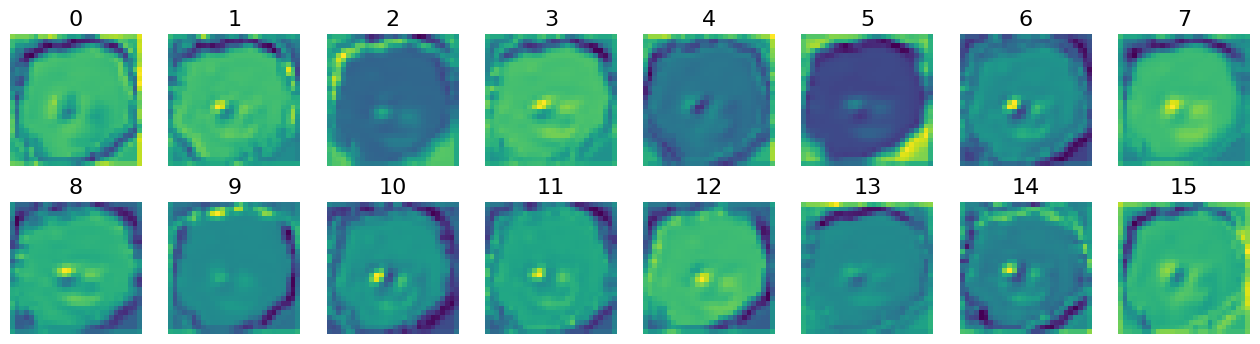

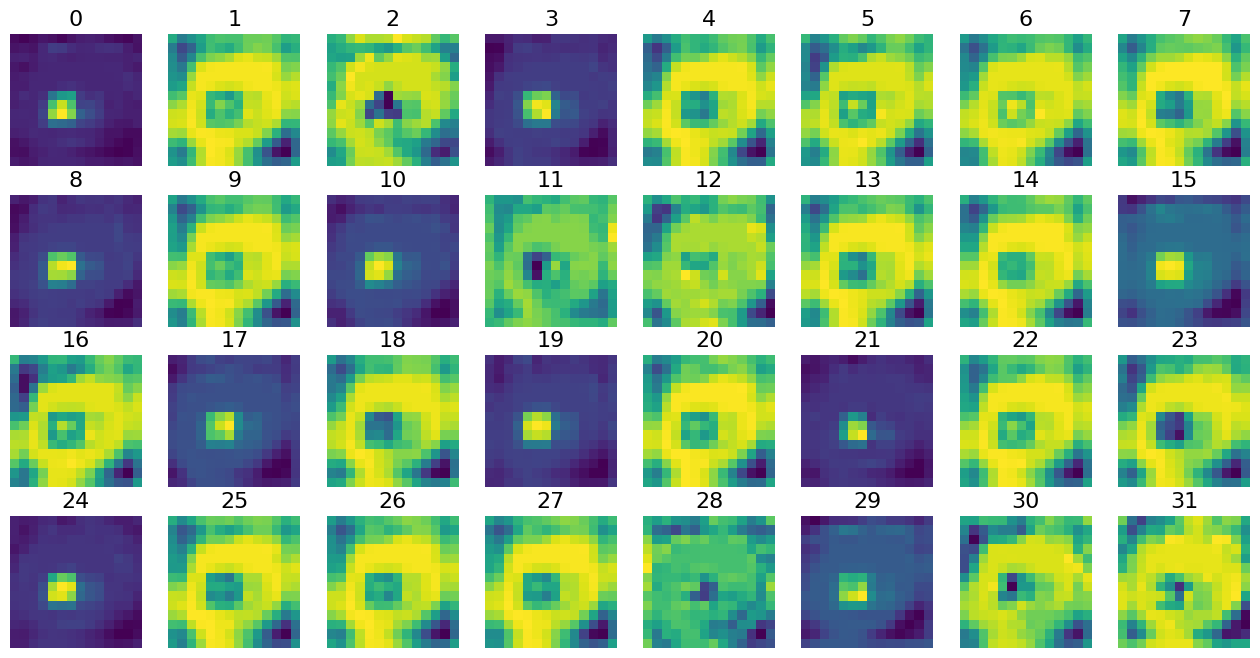

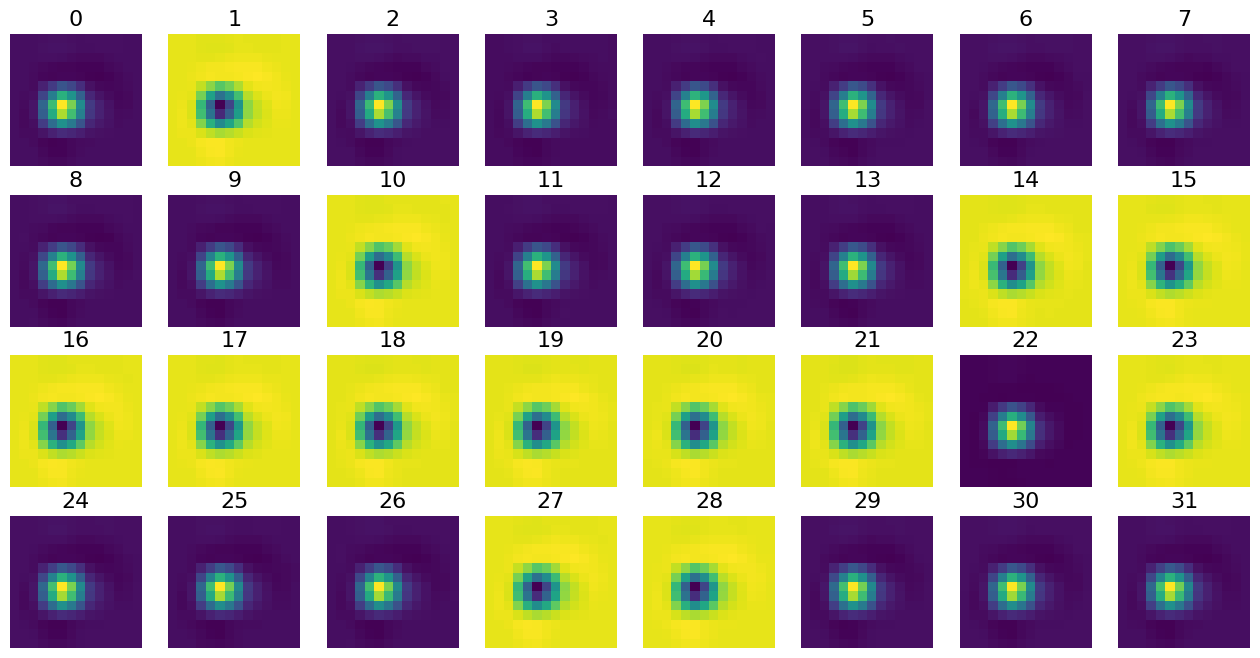

In [ ]:
def hook_func(layer, input, output):
    """Hook for activations."""
    activations = output.detach().clone()
    plot_activations(activations[0])

for block in cnn_classifier.model[0].blocks:
    layer = block.layer
    handle_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_classifier.model(image.unsqueeze(0))
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_hook.remove()

### Visualizing the Heatmaps

Use hooks to keep tracks also of the gradients in the backward pass ...

In [ ]:
hookdata = {}

def fwd_hook_func(layer, input, output):
    """Forward hook function."""
    hookdata["activations"] = output.detach().clone()

def bwd_hook_func(layer, grad_input, grad_output):
    """Backward hook function."""
    hookdata["gradients"] = grad_output[0].detach().clone()

layer = cnn_classifier.model[0].blocks[3].layer
handle_fwd_hook = layer.register_forward_hook(fwd_hook_func)
handle_bwd_hook = layer.register_full_backward_hook(bwd_hook_func)

try:
    pred = cnn_classifier.model(image.unsqueeze(0))
    pred.sum().backward()
except Exception as e:
    print(f"An error occurred during model prediction: {e}")
finally:
    handle_fwd_hook.remove()
    handle_bwd_hook.remove()

... calculate the heatmap combining activations and gradients ...

In [ ]:
from torch.nn.functional import relu

activations = hookdata["activations"][0]
gradients = hookdata["gradients"][0]

pooled_gradients = gradients.mean(dim=[1, 2], keepdim=True)
heatmap = relu((pooled_gradients * activations).sum(0)).detach().numpy()

... and plot the heatmap.

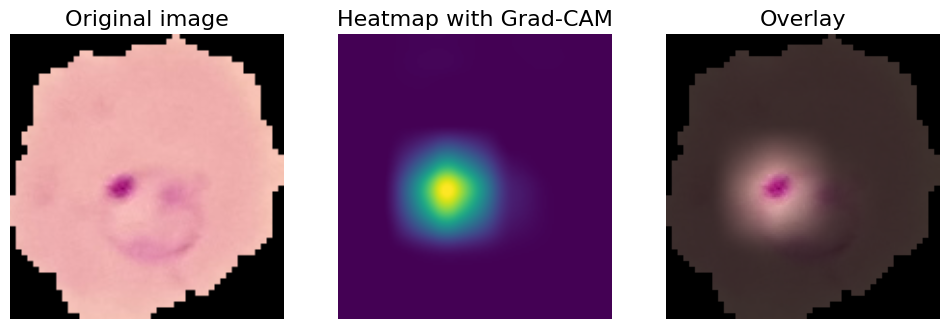

In [ ]:
from numpy import array
from skimage.exposure import rescale_intensity
from skimage.transform import resize

rescaled_image = rescale_intensity(array(image_hr), out_range=(0, 1))
resized_heatmap = resize(heatmap, rescaled_image.shape, order=2)
rescaled_heatmap = rescale_intensity(resized_heatmap, out_range=(0.25, 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(rescaled_image, interpolation="bilinear")
plt.title("Original image", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rescaled_heatmap.mean(axis=-1), interpolation="bilinear")
plt.title("Heatmap with Grad-CAM", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(rescaled_image * rescaled_heatmap)
plt.title("Overlay", fontsize=16)
plt.axis("off")

plt.show()